### Installation

In [ ]:
!pip install pettingzoo[atari] supersuit autorom pygame tqdm
!AutoROM --accept-license


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.0/552.0 kB 40.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.3/563.3 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.5/852.5 kB 56.1 MB/s eta 0:00:00
  Created wheel for multi_agent_ale_py: filename=multi_agent_ale_py-0.1.11-cp311-cp311-linux_x86_64.whl size=721821 sha256=bc001e8d5d176ff3856a7c0cc8144a47a0b3315bf15d3204eecd5f83ba6b76fd
  Stored in directory: /root/.cache/pip/wheels/1d/81/76/771ec8e34292c8a71dd6c4a52a1c0401f4d93cbfb54e02fce4
Successfully built multi_agent_ale_py
AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.11/dist-packages/AutoROM/roms
	/usr/local/lib/python3.11/dist-packages/multi_agent_ale_py/roms

Existing ROMs will be overwritten.
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/adventure.bin
Ins

In [ ]:
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
from pettingzoo.atari import space_invaders_v2
import supersuit as ss
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class DQN(nn.Module):
    def __init__(self, obs_shape, n_actions):
        super(DQN, self).__init__()
        c, h, w = obs_shape
        self.net = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        return self.net(x / 255.0)

class ReplayBuffer:
    def __init__(self, size=100000):
        self.buffer = deque(maxlen=size)

    def add(self, s, a, r, s_, d):
        self.buffer.append((s, a, r, s_, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_, d = map(np.array, zip(*batch))
        return s, a, r, s_, d

    def __len__(self):
        return len(self.buffer)


In [ ]:
class DQN(nn.Module):
    def __init__(self, obs_shape, n_actions):
        super(DQN, self).__init__()
        c, h, w = obs_shape
        self.net = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        return self.net(x / 255.0)

class ReplayBuffer:
    def __init__(self, size=100000):
        self.buffer = deque(maxlen=size)

    def add(self, s, a, r, s_, d):
        self.buffer.append((s, a, r, s_, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_, d = map(np.array, zip(*batch))
        return s, a, r, s_, d

    def __len__(self):
        return len(self.buffer)


In [ ]:
def make_env():
    env = space_invaders_v2.parallel_env()
    env = ss.color_reduction_v0(env, mode='B')
    env = ss.resize_v1(env, x_size=84, y_size=84)
    env = ss.frame_stack_v1(env, 4)
    env = ss.dtype_v0(env, np.uint8)
    return env


In [ ]:
# Training settings
NUM_EPISODES = 35
BATCH_SIZE = 32
BUFFER_SIZE = 50000
GAMMA = 0.99
LEARNING_RATE = 1e-4
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 50000
TARGET_UPDATE_FREQ = 1000
TRAIN_FREQ = 4

# Initialize env and agents
env = make_env()
agents = ["first_0", "second_0"]

# Convert obs shape to (C, H, W)
raw_obs_shape = env.observation_space("first_0").shape
obs_shape = (raw_obs_shape[-1], raw_obs_shape[0], raw_obs_shape[1])
n_actions = env.action_space("first_0").n

# Create agents and buffers
models, target_models, optimizers, buffers = {}, {}, {}, {}
for agent in agents:
    models[agent] = DQN(obs_shape, n_actions).to(device)
    target_models[agent] = DQN(obs_shape, n_actions).to(device)
    target_models[agent].load_state_dict(models[agent].state_dict())
    optimizers[agent] = optim.Adam(models[agent].parameters(), lr=LEARNING_RATE)
    buffers[agent] = ReplayBuffer(BUFFER_SIZE)


In [ ]:
def train_agents():
    cooperation_indices = []
    reward_history_A = []
    reward_history_B = []
    steps_done = 0
    shots_fired = {a: [] for a in agents}
    kills = {a: [] for a in agents}
    coexistence_times = []
    bonus_events = []

    for ep in range(NUM_EPISODES):
        obs, _ = env.reset(seed=ep)
        done = {agent: False for agent in agents}
        total_rewards = {agent: 0 for agent in agents}
        sabotages = 0
        coexistence_counter = 0
        ep_shots = {a: 0 for a in agents}
        ep_kills = {a: 0 for a in agents}

        while any(not done[agent] for agent in agents):
            actions = {}

            for agent in agents:
                if done[agent]:
                    continue

                state = torch.tensor(obs[agent], dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
                eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
                steps_done += 1

                if random.random() < eps_threshold:
                    action = random.randint(0, n_actions - 1)
                else:
                    with torch.no_grad():
                        q_values = models[agent](state)
                        action = q_values.argmax().item()

                actions[agent] = action

                if action == 1:
                    ep_shots[agent] += 1

            next_obs, rewards, terminations, truncations, _ = env.step(actions)

            for agent in agents:
                if not done[agent]:
                    buffers[agent].add(obs[agent], actions[agent], rewards[agent], next_obs[agent], terminations[agent])
                    total_rewards[agent] += rewards[agent]

                    if rewards[agent] >= 100:
                        ep_kills[agent] += 1

            if not any(terminations.values()):
                coexistence_counter += 1

            for agent in agents:
                other = [a for a in agents if a != agent][0]
                if rewards[agent] == 200 and rewards.get(other, 0) <= 0:
                    sabotages += 1
                    bonus_events.append((ep, agent))

            obs = next_obs
            done = {agent: terminations[agent] or truncations[agent] for agent in agents}

            for agent in agents:
                if len(buffers[agent]) < BATCH_SIZE:
                    continue

                states, actions_b, rewards_b, next_states, dones = buffers[agent].sample(BATCH_SIZE)

                states = torch.tensor(states, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
                actions_b = torch.tensor(actions_b).unsqueeze(1).to(device)
                rewards_b = torch.tensor(rewards_b).to(device)
                next_states = torch.tensor(next_states, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
                dones = torch.tensor(dones).to(device)

                q_values = models[agent](states).gather(1, actions_b).squeeze()
                next_q_values = target_models[agent](next_states).max(1)[0].detach()
                if not isinstance(dones, torch.Tensor):
                    dones = torch.tensor(dones, dtype=torch.float32)
                else:
                    dones = dones.clone().detach().float()
                dones = dones.to(device)


                expected_q_values = rewards_b + GAMMA * next_q_values * (1 - dones)


                loss = nn.MSELoss()(q_values, expected_q_values)
                optimizers[agent].zero_grad()
                loss.backward()
                optimizers[agent].step()

        # Save episode-level metrics
        for a in agents:
            shots_fired[a].append(ep_shots[a])
            kills[a].append(ep_kills[a])
        coexistence_times.append(coexistence_counter)

        score_first = total_rewards["first_0"]
        score_second = total_rewards["second_0"]
        reward_history_A.append(score_first)
        reward_history_B.append(score_second)

        score_gap = abs(score_first - score_second)
        total_score = score_first + score_second
        cooperation_score = total_score - score_gap
        cooperation_index = cooperation_score / (total_score + 1e-6)
        cooperation_indices.append(cooperation_index)

        print(f"Episode {ep+1:3d} | A: {score_first:.0f} | B: {score_second:.0f} | CoopIdx: {cooperation_index:.2f}")
        # print(f"Sabotages: {sabotages}")
        # print(f"Bonus Events: {bonus_events}")
        # print(f"Coexistence Time: {coexistence_counter}")
        # print(f"Shots Fired: {shots_fired}")
        # print(f"Kills: {kills}")

    return cooperation_indices, reward_history_A, reward_history_B, shots_fired, kills, coexistence_times, bonus_events

cooperation_indices, reward_history_A, reward_history_B, shots_fired, kills, coexistence_times, bonus_events = train_agents()


Episode   1 | A: 355 | B: 535 | CoopIdx: 0.80
Episode   2 | A: 535 | B: 380 | CoopIdx: 0.83
Episode   3 | A: 505 | B: 245 | CoopIdx: 0.65
Episode   4 | A: 260 | B: 455 | CoopIdx: 0.73
Episode   5 | A: 450 | B: 250 | CoopIdx: 0.71
Episode   6 | A: 440 | B: 415 | CoopIdx: 0.97
Episode   7 | A: 790 | B: 220 | CoopIdx: 0.44
Episode   8 | A: 570 | B: 395 | CoopIdx: 0.82
Episode   9 | A: 35 | B: 655 | CoopIdx: 0.10
Episode  10 | A: 250 | B: 410 | CoopIdx: 0.76
Episode  11 | A: 250 | B: 430 | CoopIdx: 0.74
Episode  12 | A: 725 | B: 540 | CoopIdx: 0.85
Episode  13 | A: 430 | B: 205 | CoopIdx: 0.65
Episode  14 | A: 430 | B: 200 | CoopIdx: 0.63
Episode  15 | A: 20 | B: 610 | CoopIdx: 0.06
Episode  16 | A: 265 | B: 495 | CoopIdx: 0.70
Episode  17 | A: 455 | B: 425 | CoopIdx: 0.97
Episode  18 | A: 285 | B: 555 | CoopIdx: 0.68
Episode  19 | A: 930 | B: 300 | CoopIdx: 0.49
Episode  20 | A: 570 | B: 755 | CoopIdx: 0.86
Episode  21 | A: 430 | B: 275 | CoopIdx: 0.78
Episode  22 | A: 700 | B: 300 | Coop

# Rewards per Episode (Agent A vs Agent B)

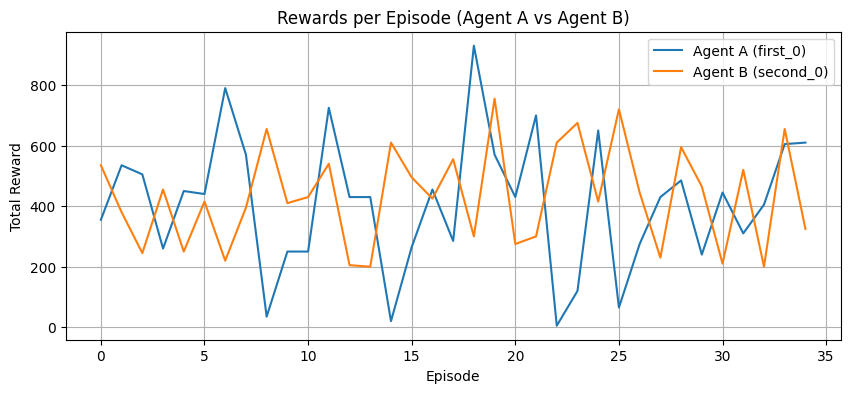

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(reward_history_A, label="Agent A (first_0)")
plt.plot(reward_history_B, label="Agent B (second_0)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Rewards per Episode (Agent A vs Agent B)")
plt.legend()
plt.grid(True)
plt.show()

# Cooperation Index Across Episodes

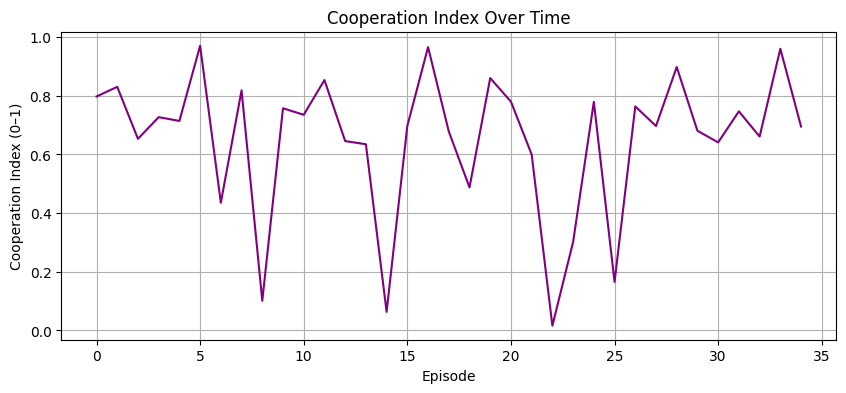

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(cooperation_indices, color="purple")
plt.xlabel("Episode")
plt.ylabel("Cooperation Index (0–1)")
plt.title("Cooperation Index Over Time")
plt.grid(True)
plt.show()

# Reward Gap (Absolute Difference) Over Episodes

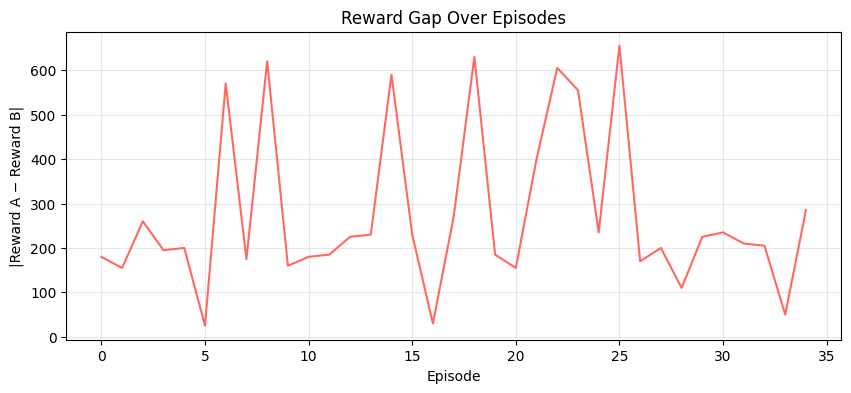

In [ ]:
reward_gap = [abs(a - b) for a, b in zip(reward_history_A, reward_history_B)]

plt.figure(figsize=(10, 4))
plt.plot(reward_gap, color="#FF6961")
plt.xlabel("Episode")
plt.ylabel("|Reward A − Reward B|")
plt.title("Reward Gap Over Episodes")
plt.grid(True, alpha=0.3)
plt.show()


# Final Episode: Reward Comparison

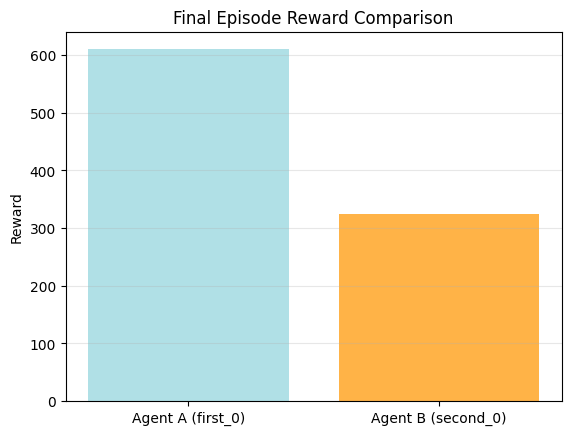

In [ ]:
labels = ['Agent A (first_0)', 'Agent B (second_0)']
final_rewards = [reward_history_A[-1], reward_history_B[-1]]

plt.bar(labels, final_rewards, color=["#B0E0E6", "#FFB347"])
plt.title("Final Episode Reward Comparison")
plt.ylabel("Reward")
plt.grid(axis='y', alpha=0.3)
plt.show()


#Smoothed Rewards (Moving Average)
#### Shows underlying trends without noise.

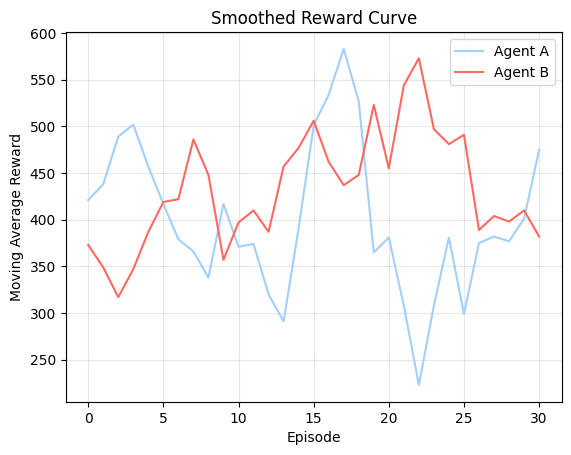

In [ ]:
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.plot(moving_average(reward_history_A), label="Agent A", color="#A2CFFE")
plt.plot(moving_average(reward_history_B), label="Agent B", color="#FF6961")
plt.title("Smoothed Reward Curve")
plt.xlabel("Episode")
plt.ylabel("Moving Average Reward")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


#Cumulative Reward Plot
#### Total learning progression over time.

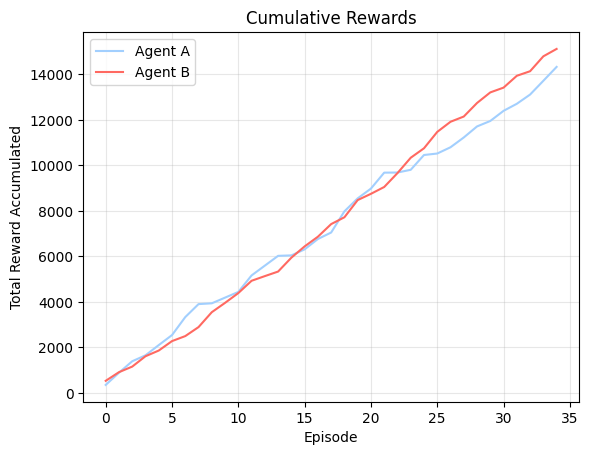

In [ ]:
cum_A = np.cumsum(reward_history_A)
cum_B = np.cumsum(reward_history_B)

plt.plot(cum_A, label="Agent A", color="#A2CFFE")
plt.plot(cum_B, label="Agent B", color="#FF6961")
plt.title("Cumulative Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward Accumulated")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


#Histogram of Episode Rewards
#### Distribution of performance over time.

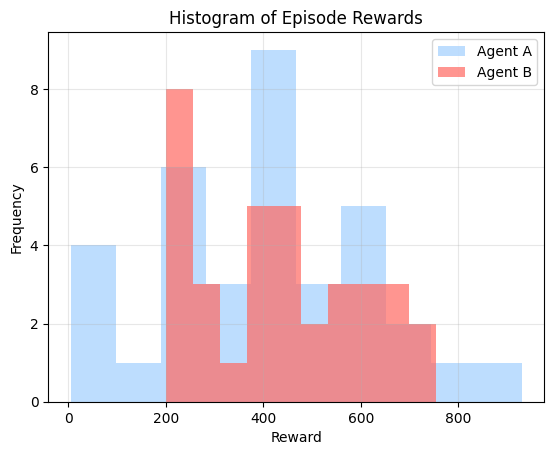

In [ ]:
plt.hist(reward_history_A, bins=10, alpha=0.7, label="Agent A", color="#A2CFFE")
plt.hist(reward_history_B, bins=10, alpha=0.7, label="Agent B", color="#FF6961")
plt.title("Histogram of Episode Rewards")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
from pettingzoo.atari import space_invaders_v2
import supersuit as ss
import torch
import imageio
import numpy as np
from IPython.display import Video, display

# Set up evaluation environment
eval_env = space_invaders_v2.parallel_env(render_mode="rgb_array")
eval_env = ss.color_reduction_v0(eval_env, mode='B')
eval_env = ss.resize_v1(eval_env, x_size=84, y_size=84)
eval_env = ss.frame_stack_v1(eval_env, 4)
eval_env = ss.dtype_v0(eval_env, np.uint8)

obs, _ = eval_env.reset(seed=42)
frames = []

for _ in range(300):
    actions = {}
    for agent in eval_env.agents:
        with torch.no_grad():
            s = torch.tensor(obs[agent], dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
            q = models[agent](s)
            actions[agent] = q.argmax().item()
    obs, _, terminations, truncations, _ = eval_env.step(actions)
    frames.append(eval_env.render())
    if all(terminations.values()) or all(truncations.values()):
        break

eval_env.close()

# Save video file
video_path = "/mnt/data/agent_playback.mp4"
imageio.mimsave(video_path, frames, fps=15)

# Display inline video
display(Video(video_path))